## A Look a Heart Failure

By: Rajesh Lamichhane, 03 October 2022

<hr style="border-bottom: 10px groove black; margin-top: 1px; margin-bottom: 1px"></hr>

### Project Goals:
    
The goals of this project are the predict the factors the lead to death event of patient having heart failure symptoms, to produce a prediction model using ML algorithms and to offer recommendation to reduce such deah event 

### Project Description
In this project, I will analyse a datase of 299 patients wih heart faliure collected in 2015. I will used exploratory analysis followed by some statiscal testing to find some important factors leading to heartfaliure deaths and then apply classiifcation ML algorithms to make model that can predict the death event.

### Initial Questions
1. How likely is death due to heart failure?
2. How is age related?
3. Is there is any link age and time?
4. How does creatinine affect death event?
5. How does ejection fraction relate?
6. Does all ailemnts combined create higher chances of death event?

#### Imports

In [2]:
# tabular data manipulation:
import pandas as pd
import numpy as np

import wrangle
import viz

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

#for hypothesis tests
import scipy.stats as stats

#sklearn metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest,RFE, f_regression
from sklearn.preprocessing import MinMaxScaler

# mute warrning
import warnings
warnings.filterwarnings("ignore")

#seaborn setting
plt.rc('figure', figsize=(12,8 ))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

### Acquire Data
I acquired the data from Kaggle. It is a csv format which is saved locally.

In [4]:
#acquire data
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [5]:
#take a peek at the data
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
#shape of data
df.shape

(299, 13)

In [5]:
#check the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


Acquire takeaways
> - Data has 299 rows and 13 columns
> - All rows have numeric datatype
> - There is no null values
> - One column is upper case

#### Data Preparation

Since our data is already clean, we do not need to do much here. We may have outlier but our sample size is small this time so we will discard it. We will change death event column to lowercase and split the data into train, validate,test.

In [6]:
#change column into lowe case
df.columns = df.columns.str.lower()

In [7]:
#split data into train (56%), validate(24%), test(20%)
#stratify on death_event
train, validate,test= wrangle.split_data(df)

In [8]:
# shape after split
train.shape, validate.shape, test.shape

((167, 13), (72, 13), (60, 13))

### Explore Data

    Important note: I will do exploration analysis only in train data


Answers to my initial questions:



1. How likely is death due to heart failure?

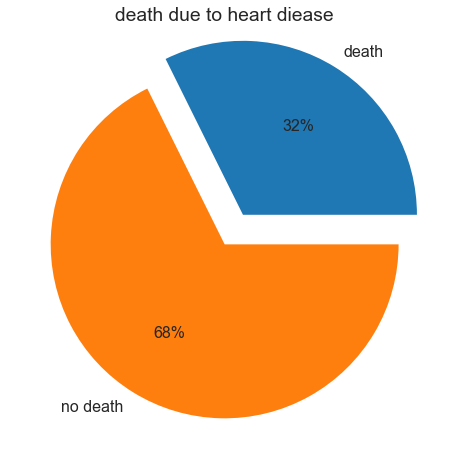

In [9]:
viz.plot_pie(train)

    32% died due to the heartfailure.

2. How is age related?

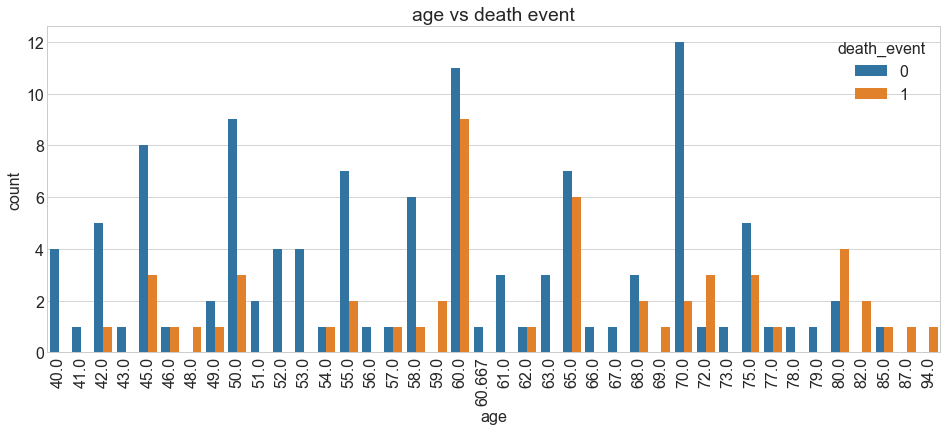

In [10]:
viz.plot_age(train)

    seems like for people below 60 years, probably of death event is smaller
    at age 60, the probability of death or no death is almost similar
    as age increase, likelihood of death event seems increases

In [11]:
#run 2 sample t test
viz.run_age_t_test(train)

null_hyp: mean age of people with death event == mean age of people with no death event 
alternate_hyp:  mean age of people with death event != mean age of people with no death event 

reject null hypothesis
we conclude  mean age of people with death event != mean age of people with no death event 


3. Is there is any link age and time?

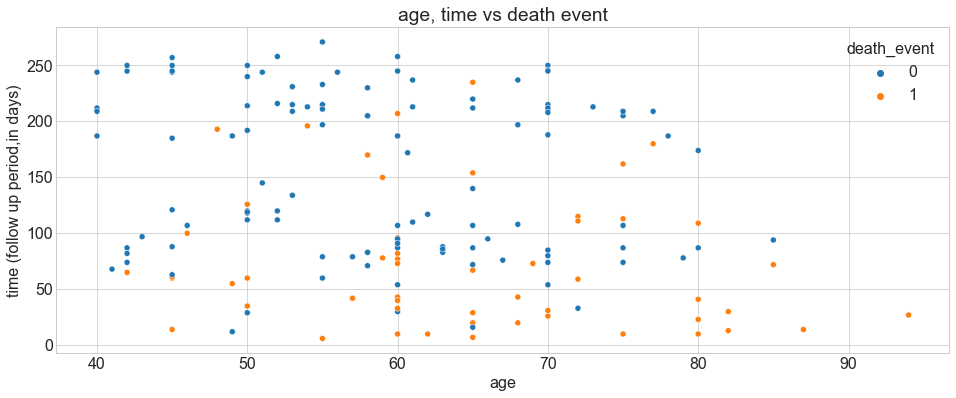

In [12]:
viz.plot_age_vs_time(train)

    it looks like, at old age, death is high even if time (follow up ) is smaller

4. How does creatinine affect death event?

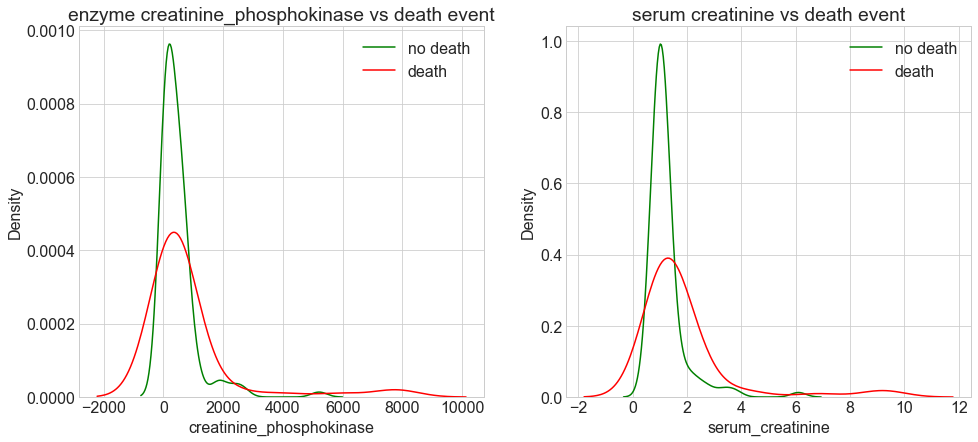

In [13]:
viz.plot_creatinine(train)

    people who died seem to have higher level creatinine phosphokinase(cpk) and serum_creatinine in thier blood. They both are seen in higher amount in blood as response of organ damage or failure.

5. How does ejection fraction relate?

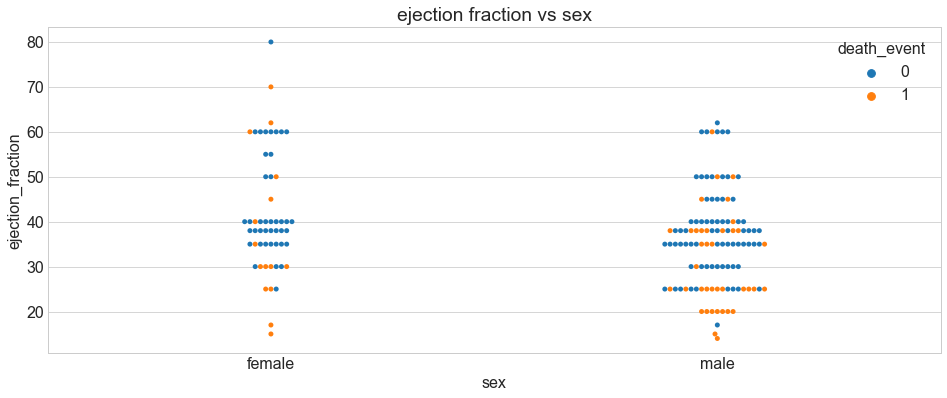

In [14]:
viz.plot_ejection_fraction_vs_sex(train)

    we can see most deaths have occured in both sex at lower ejection fraction. Clinically, a healthy ejection fraction is between 55-75%.

6. Lets see what happens if we add all aliments (anaemia, diabetes, high_blood_pressure, smoking) 

In [15]:
#create new columns by add the columns binary columns representing ailment
train["add_ailments"] = (train[["anaemia","diabetes","high_blood_pressure", "smoking"]]==1).sum(axis =1 )

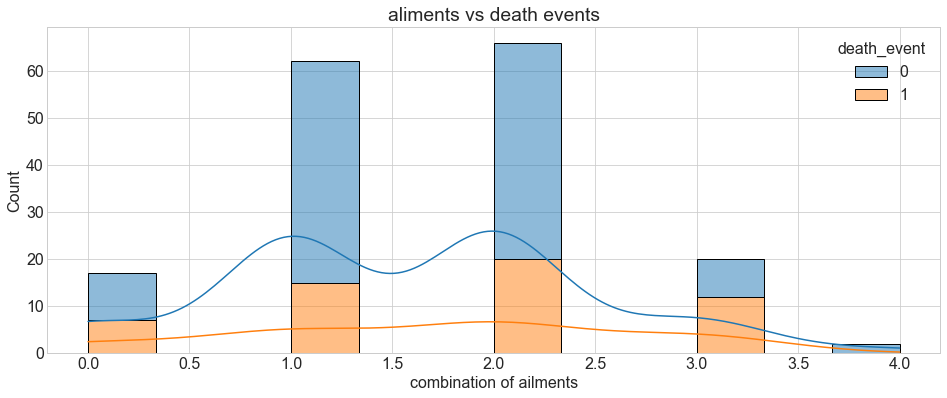

In [16]:
viz.plot_add_ailments(train)

    This is not expected. Combination of ailments did not seem to increase in death event as much as I assumsed.

### Modeling

We are going to use select_kbest to select our best feautures

In [17]:
#set up for select k best
#set X and y
X = train.drop(columns = ["death_event"])
y = train.death_event

In [18]:
#call in select_kbest function
viz.select_kbest(X,y,k=4)

Index(['age', 'ejection_fraction', 'serum_creatinine', 'time'], dtype='object')

    we will use age, ejection fraction, serum creatinine and time in our models

#### Scale the features(columns) using MinMax scaler

In [19]:
#the return from select k_best will be our features that first needs to be scaled
columns = viz.select_kbest(X,y,k=4)
# we need to scale them before fitting them to model
scaled_train,scaled_validate,scaled_test = viz.scale_data(train,validate,test,columns)

In [20]:
#subset of scaled features
features = ["age_scaled","ejection_fraction_scaled","serum_creatinine_scaled","time_scaled"]

In [21]:
#set up X and y
X_train = scaled_train[features]
y_train = scaled_train.death_event
X_validate = scaled_validate[features]
y_validate = scaled_validate.death_event
X_test = scaled_test[features]
y_test = scaled_test.death_event

#### Baseline:
Baseline prediction is the mode value, which is 0 in our case

In [22]:
#run funtion to calculate baseline accuracy
viz.get_baseline(y_train)

0    113
1     54
Name: death_event, dtype: int64

baseline accuracy is: 0.6766


Model 1 : Decision Tree

In [23]:
#call the model object
dt = DecisionTreeClassifier(max_depth=3, random_state =123)
#fit the model
dt.fit(X_train, y_train)
#accuracy of train
accuracy_train = dt.score(X_train,y_train)
#accuracy of validate
accuracy_validate = dt.score(X_validate,y_validate)

output = {"accuracy_train" : accuracy_train, "accuracy_validate":accuracy_validate}
pd.DataFrame(output, index=[0])


,accuracy_train,accuracy_validate
0,0.850299,0.875


    Decision tree has 85.02% accuracy on train and 87.5 % accuracy on validate data

Model 2 : Random Forest

In [24]:
#creat the model object
rf = RandomForestClassifier(min_samples_leaf= 8 ,random_state=123)
#fit the object
rf.fit(X_train, y_train)
#accuracy of train
accuracy_train = rf.score(X_train,y_train)
#accuracy of validate
accuracy_validate = rf.score(X_validate,y_validate)
output = {"accuracy_train":accuracy_train,"accuracy_validate":accuracy_validate}

df = pd.DataFrame(output, index = [0])
df

,accuracy_train,accuracy_validate
0,0.850299,0.888889


    Random Forest has 85.02% accuracy on train and 88.88 % accuracy on validate data

Model 3: KNN

In [25]:
#create KNN object
knn = KNeighborsClassifier(n_neighbors = 5 )
#fit the object
knn.fit(X_train,y_train)
#accuracy of train
accuracy_train = knn.score(X_train,y_train)
#accuracy of validate
accuracy_validate = knn.score(X_validate,y_validate)

output = {"accuracy_train":accuracy_train,"accuracy_validate":accuracy_validate}

df = pd.DataFrame(output, index = [0])
df

,accuracy_train,accuracy_validate
0,0.850299,0.861111


    KNN has 85.02% accuracy on train and 86.11% accuracy in validate data

### Prediction using best model

Our best model is KNN. It is the least over fit of all three model. It was able to beat baseline by 17%

In [26]:
#print test accuracy
print('Accuracy of KNN on test set: {:.4f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN on test set: 0.8500


we can also make prediction table

In [27]:
# predict outcome on test
y_pred_test= knn.predict(X_test)
#predict probability on test 
y_proba = knn.predict_proba(X_test)
#Create empty DataFrame:
predictions = pd.DataFrame()
#Create customer_id column:
predictions['age'] = test.age
#Create prediction column:
predictions['prediction'] = y_pred_test
#Createprobability column:
predictions['probability'] = y_proba[:,1]

In [28]:
predictions.head()

,age,prediction,probability
296,45.0,0,0.0
55,95.0,1,0.8
202,70.0,0,0.2
26,95.0,1,1.0
98,60.0,0,0.4


### Conclusion/ Recommendation:

> - On 299 people, mortality due to heart faliure is 32%
> - Our best model is KNN with accuracy of 85 % and beats baseline by 17%.
> - We used age, ejection fraction, serum creatinine and time as features in our models
> - Age over 60 years are vulnerable times for the heart
> - At old age, death event is high even if time (follow up ) is smaller
> - Monitoring the levels of creatinine phosphokinase(cpk) and serum_creatinine is crucial
> - Ejection fraction dips down below healthly limits in cases of death
> - Combination of ailements such as anaemia, diabetes did not produced as expected observation in death event
> - Additional information about the physical features of the patients (height, weight, body mass index, etc) can be heplful
> - People's occupational history would have been useful to detect additional risk factors for cardiovascular health disease

### If I had more time

I would do more EDA and look for more recent data.